# Кластерный анализ

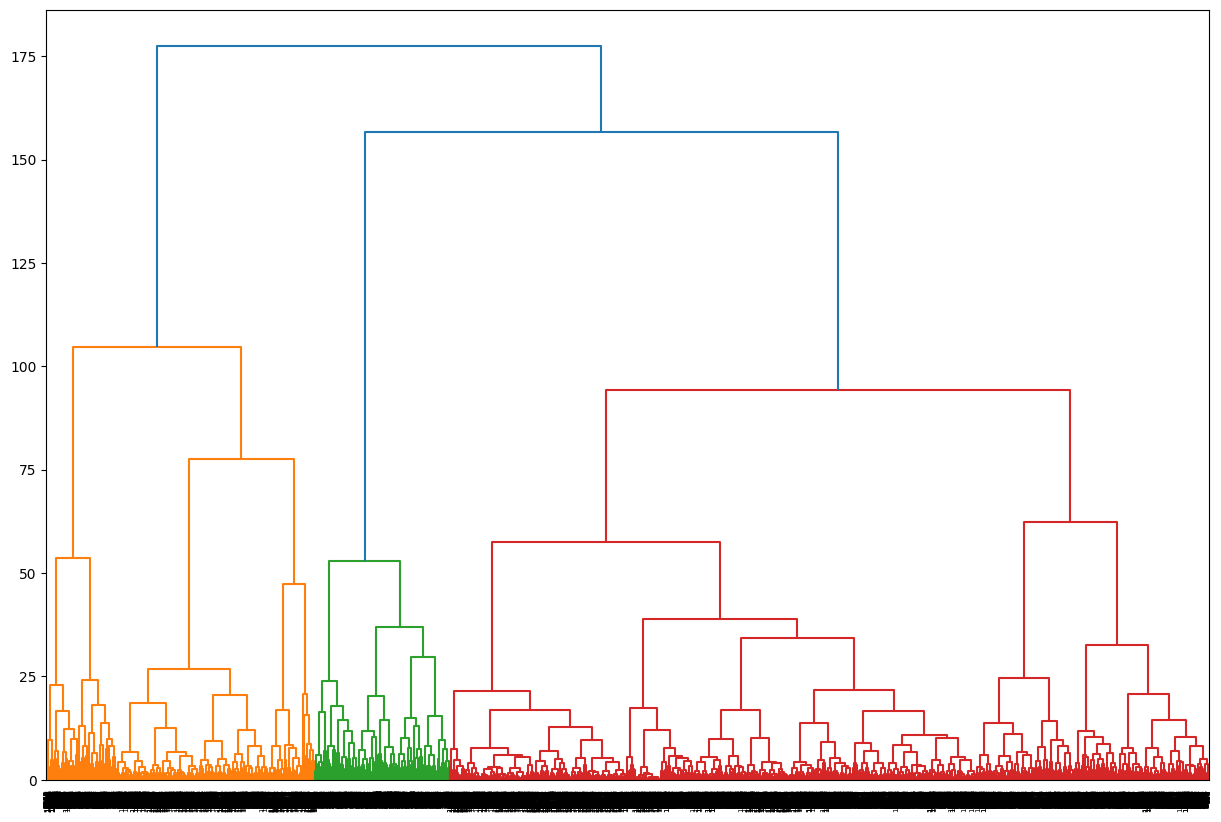

In [14]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

data = pd.read_csv('extended_data.csv', sep = ';', index_col=0)

metric_vars = ['year', 'price', 'owner_count', 'engine_volume_liters', 'power_in_hp', 'mileage']


data = data.dropna(subset=metric_vars)
for i in metric_vars:
    data['z_' + i] = (data[i] - data[i].mean()) / data[i].std()


metric_vars_norm = list(map(lambda x: 'z_' + x, metric_vars))
plt.figure(figsize=(15, 10))
dn = dendrogram(linkage(data[metric_vars_norm], 'ward'))

### Вычислим индекс Калински–Харабаша

In [15]:
from sklearn.metrics import calinski_harabasz_score
from IPython.display import Latex
Z = linkage(data[metric_vars_norm], method='ward', metric='euclidean')

for k in range (2, 10):
    labels = fcluster(Z, t=k, criterion='maxclust')
    display(Latex('Число кластеров: {}, индекс {}'.format(k, calinski_harabasz_score(data[metric_vars_norm], labels))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Максимальное расстояние при 3-х кластерах $⟹$ берем 3 кластера.

In [16]:
labels = fcluster(Z, t=3, criterion='maxclust') #проводим расчёты для 3-х кластеров
data['culster_labels'] = labels

In [17]:
data.groupby('culster_labels')[metric_vars].mean()

,year,price,owner_count,engine_volume_liters,power_in_hp,mileage
culster_labels,,,,,,
1,2017.023838,7.682089e+06,2.584242,3.509616,350.581414,93081.826667
2,1997.753226,6.396754e+05,6.891935,2.365323,163.000000,319837.154032
3,2015.409892,2.921244e+06,2.947097,2.097663,197.075842,133176.449319


In [18]:
grouped = data.groupby('culster_labels').size().reset_index(name='all_count')
grouped_audi = data[data['manufacturer'] == 'Audi'].groupby('culster_labels').size().reset_index(name='audi_count')
grouped_mercedes = data[data['manufacturer'] == 'Mercedes-Benz'].groupby('culster_labels').size().reset_index(name='mercedes_count')
grouped_bmw = data[data['manufacturer'] == 'BMW'].groupby('culster_labels').size().reset_index(name='bmw_count')

result = pd.merge(grouped, grouped_audi, on='culster_labels')
result = pd.merge(result, grouped_bmw, on='culster_labels')
result = pd.merge(result, grouped_mercedes, on='culster_labels')

result['percentage_audi'] = (result['audi_count'] / result['all_count']) * 100
result['percentage_mercedes'] = (result['mercedes_count'] / result['all_count']) * 100
result['percentage_bmw'] = (result['bmw_count'] / result['all_count']) * 100
result

,culster_labels,all_count,audi_count,bmw_count,mercedes_count,percentage_audi,percentage_mercedes,percentage_bmw
0,1,2475,312,1128,1035,12.606061,41.818182,45.575758
1,2,1240,414,429,397,33.387097,32.016129,34.596774
2,3,6975,1574,2698,2703,22.566308,38.752688,38.681004


In [19]:
import numpy as np
color_groups = ['black', 'white', 'grey_silver', 'blue_brown', 'red', 'other']
def color_group(x):
    if pd.isna(x):
        return np.nan
    for i in color_groups:
        if x in i:
            return i
    return 'other'

data['color_group'] = data['color'].apply(color_group)

pd.crosstab(data['culster_labels'], data['color_group']).apply(lambda r: r*100/r.sum(), axis=1)

color_group,black,blue_brown,grey_silver,other,red,white
culster_labels,,,,,,
1,46.967847,13.146113,16.931217,3.540904,1.709402,17.704518
2,29.562345,17.671346,28.075970,12.881916,4.541701,7.266722
3,37.339674,15.996541,15.621848,3.631647,4.496325,22.913965


In [20]:
pd.crosstab(data['culster_labels'], data['is_sport_line']).apply(lambda r: r*100/r.sum(), axis=1)

is_sport_line,False,True
culster_labels,,
1,85.160328,14.839672
2,99.898271,0.101729
3,99.007718,0.992282


In [21]:
pd.crosstab(data['culster_labels'], data['is_crossover']).apply(lambda r: r*100/r.sum(), axis=1)

is_crossover,False,True
culster_labels,,
1,35.878788,64.121212
2,88.145161,11.854839
3,64.817204,35.182796


In [22]:
pd.crosstab(data['culster_labels'], data['transmission']).apply(lambda r: r*100/r.sum(), axis=1)

transmission,automatic,manual,robot,variator
culster_labels,,,,
1,97.048120,0.080873,2.871007,0.000000
2,47.657512,48.626817,0.646204,3.069467
3,74.562661,1.132779,20.461715,3.842845


#### Самые распространенные модели в каждом кластере

In [23]:

data['model_full'] = data['manufacturer'] + " " + data['model']
data.groupby('culster_labels')['model_full'].value_counts().groupby(level=0).nlargest(20)

culster_labels  culster_labels  model_full               
1               1               BMW X5                       342
                                Mercedes-Benz S-Class        287
                                BMW X6                       252
                                Mercedes-Benz GLS-Class      166
                                Mercedes-Benz GLE            143
                                BMW X7                       120
                                BMW 7-Series                 111
                                BMW 5-Series                 105
                                Mercedes-Benz G-Class        103
                                Audi Q7                      100
                                Mercedes-Benz GLE Coupe       88
                                Audi Q8                       59
                                Mercedes-Benz GL-Class        54
                                Audi A8                       52
                                

## Описание кластеров
### Кластер 1 - самые дорогие автомобили

    - около 2017 года выпуска
    - самые дорогие автомобили
    - самые мощные, самый большой средний объем двигателя
    - 13% - Audi, 42% - Mercedes, 45% - BMW
    - 46% - черные, равномерное распределены (по 13-16%) синие, коричневые, белые и серые цвета
    - В этом кластере доля черных наибольшая
    - 8% автомобилей из спортивной линейки (самый высокий показатель)
    - 64% автомобилей - кроссоверы (самый высокий показатель)
    - Наиболее распространены премиальные модели (BMW X5, Mercedes G-class, Audi Q7)

### Кластер 2 - "старички"

    - около 1997 года выпуска 
    - самые дешевые
    - самый большой пробег
    - Равномерно распределены между BMW, Mercedes и Audi
    - Наиболее распространенные цвета - черный, белый серебристый
    - Меньше всего кроссоверов (11%)
    - Больше всего механики (48%)
    - Кластер содержит разнообразные модели

### Кластер 3 - "обычные"

    - около 2015 года выпуска
    - средние по цене
    - Audi - 22%, равные доли у Mercedes и BMW
    - Наибольшая доля белых автомобилей
